<font size="5">Run the ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- initiate the model with elevation, friction, stage
- set the boundary conditions
- run the model!



</font>

<font size="3">Before you can run this notebook, you should have run the 4_Build_ANUGA_Mesh</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True. If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
yes_colab = False

In [2]:
import sys
import os
from pathlib import Path
your_path = Path(os.getcwd())

<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [3]:
if yes_colab:
  where_to_mount = '/content/drive/'
  from google.colab import drive
  drive.mount(where_to_mount, force_remount=True)
  mounted_drive = where_to_mount + 'MyDrive/' 
  sys.path.append('/content/drive/MyDrive/installations')
else:
  mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))

Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [4]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [5]:
print(mounted_drive)

/Users/alchrist/Documents/GitHub/BAM


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [6]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))
print(path_code)

path_examples = mounted_drive / 'examples'
Path(path_examples).mkdir(parents=True, exist_ok=True)

/Users/alchrist/Documents/GitHub/BAM/scripts


In [7]:
## All necessary files are zipped here
!unzip -n $path_examples/komo.zip -d $path_examples 

## !unzip -n komo_estuary_tutorial/komo_starter.zip -d $mounted_drive 


Archive:  /Users/alchrist/Documents/GitHub/BAM/examples/komo.zip


<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [8]:
# Standard packages
import os
import time
import sys
import fnmatch
import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
from datetime import datetime
from string import Template
import geopandas as gpd
from shapely.geometry import Polygon, Point
import rasterio
from pathlib import Path
from shapely.geometry import LineString
from osgeo import gdal

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier, Inlet_operator

## Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

#mpl.rcParams['animation.ffmpeg_path'] = r'/Users/alchrist/Downloads/ffmpeg'
## If you get an error with producing animation plots, uncomment the line above and add directory for ffmpeg (r'/PATH/TO/ffmpeg')
import matplotlib.animation as animation
writer = animation.FFMpegWriter(fps=60)



/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_50172/2126292836.py:12: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopand

In [9]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)


<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

In [11]:
AOI = 'komo'

Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/komo
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
#########

<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

<font size=3> Give the name of your study area, must be the same in all notebooks </font>


In [41]:
elev_name = folders[4] / 'Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30'
print('DEM = %s' %(elev_name))

mesh_name = folders[3] / 'Meshes_base_100000m2' / 'Meshes_base_100000m2.tsh'
print('MESH = %s' %(mesh_name))

inletLAT = 19092.
inletLON = 608911.
tideLAT = 31223.17
tideLON = 502794.61 
tideLAT_4326 = 0.2825
tideLON_4326 = 9.0253

boundary_types = ('Br','Bout')

DEM = /Users/alchrist/Documents/GitHub/BAM/examples/komo/DEMs/Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30
MESH = /Users/alchrist/Documents/GitHub/BAM/examples/komo/Meshes/Meshes_base_100000m2/Meshes_base_100000m2.tsh


In [17]:
tide_data = np.genfromtxt(folders[5] / ('Tide_LAT%s_LON%s' %(tideLAT_4326,tideLON_4326)) / ('%s_tides_20100101.csv' %(AOI)),delimiter=',')


In [19]:
parameters = pd.read_csv(folders[6] / ('config_%s.csv' %(AOI)))

EPSG = int(parameters['EPSG'])
landcovermethod = parameters['LandcoverMethod'][0]
discharge = 300

print(parameters.iloc[0] )

Unnamed: 0.1                               0
Unnamed: 0                                 0
AOI                                     komo
RiverOceanBoundary                      1260
Discharge                                426
LandcoverMethod                   WorldCover
LandElevMethod                         GLO30
OceanElevMethod                        GEBCO
LowerRiverElevMethod                   plane
UpperRiverElevMethod                 wdpower
WetlandElevMethod               constant_0.5
LakeElevMethod                    constant_1
ManningLUT                           default
WetlandClass                              90
WD_POWERA_upper                       0.0606
WD_POWERB_upper                       0.7732
MaxOceanDepth                           -300
MaxNearshoreDepth                       -300
MaxRiverDepth                           -300
MaxRiverWidth                            756
ulx                                   501794
lry                                    -2259
lrx       

In [20]:
now = datetime.now()
startdate = '20210101'
enddate = '20210103'
simu_length    = (datetime.strptime(enddate,'%Y%m%d')-datetime.strptime(startdate,'%Y%m%d')).days


In [25]:
scenario = 'Test1'
print(scenario)
modelpath = folders[6] / scenario
print(modelpath)

Path((folders[6] / scenario)).mkdir(parents=True, exist_ok=True)



Test1
/Users/alchrist/Documents/GitHub/BAM/examples/komo/Simulations/Test1


In [27]:
from rasterio.mask import mask
AOI_extent = gpd.read_file(folders[7] / ('%s_extent_%s.shp' %(AOI,EPSG)))
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res)))
masked, mask_transform = mask(dataset=watermask,shapes=AOI_extent.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]


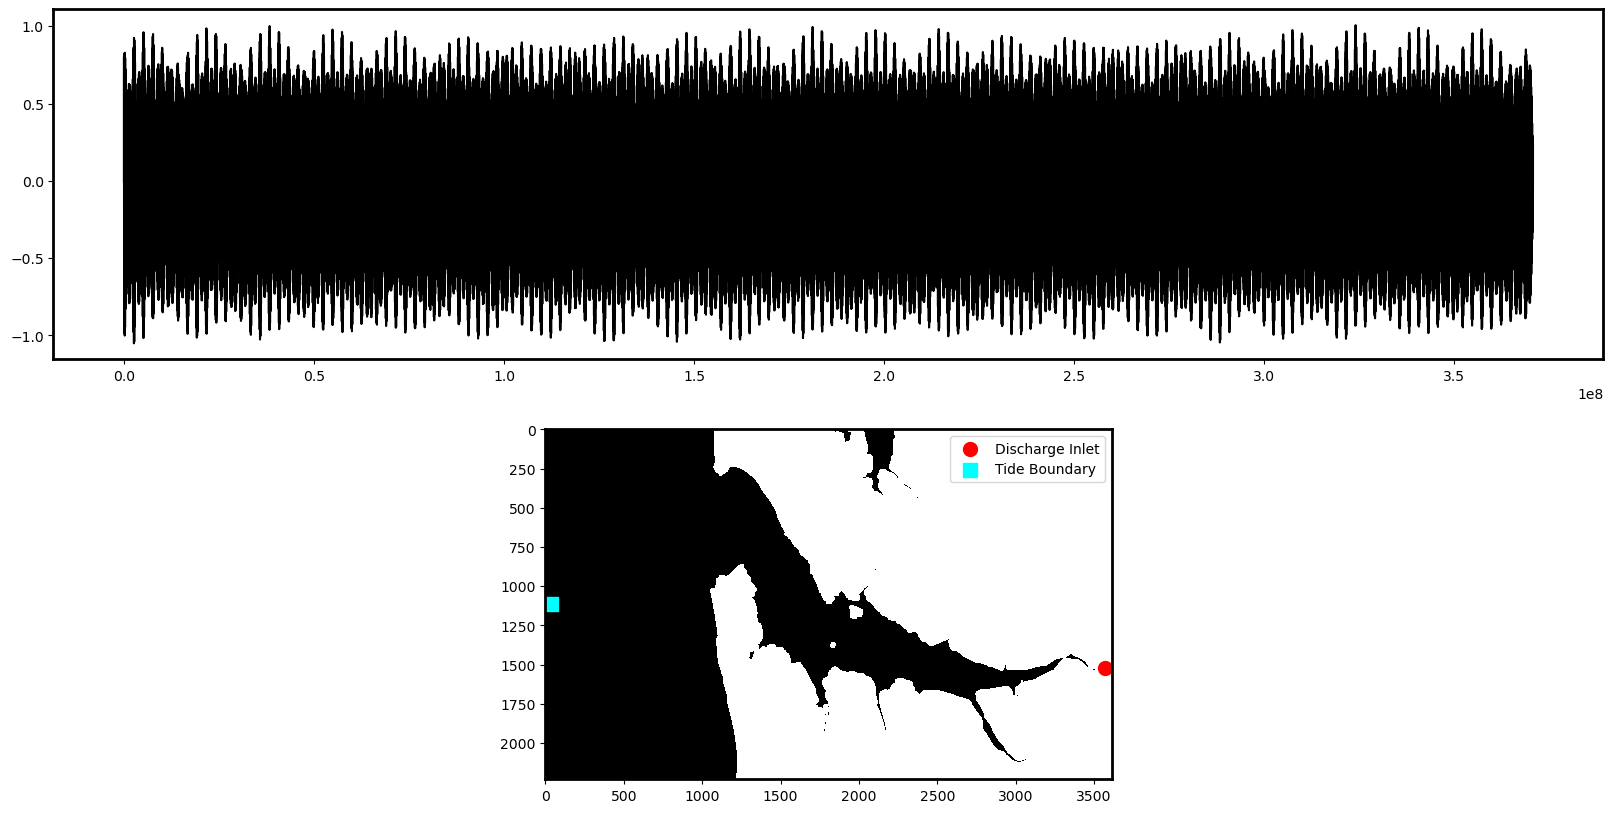

In [28]:
fig,[ax2,ax3] = plt.subplots(nrows=2,figsize=(20,10))

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON-origin_x)/res,(origin_y - inletLAT)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tideLON-origin_x)/res,(origin_y - tideLAT)/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

plt.savefig(folders[5] / ('%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(AOI,tideLAT,tideLON,inletLAT,inletLON)),bbox_inches='tight')

In [68]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)

domain = anuga.create_domain_from_file(str(mesh_name))
domain.set_name(scenario) # Name of sww file
domain.set_datadir(str(modelpath))
domain.set_low_froude(1)
domain.set_flow_algorithm('DE1')
domain.set_minimum_allowed_height(0.02)
domain.report_water_volume_statistics
#print(domain.statistics())
domain.store_centroids = True
##############################################################################
##############################################################################

<font size=5 color='red'> Apply the DEM to the model domain </font>

In [70]:
## Bed elevation

gdal.Translate(str(elev_name) + '.asc', str(elev_name) + '.tif', format='AAIGrid',noData =-9999)
domain.set_quantity('elevation', filename= str(elev_name) + '.asc', location = 'centroids')
print('################################# Elevation made with:     %s_%s.asc' %(AOI,elev_name))


################################# Elevation made with:     komo_/Users/alchrist/Documents/GitHub/BAM/examples/komo/DEMs/Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30.asc


<font size=5 color='red'> Apply the Manning coefficients to the model domain </font>

In [71]:
## Manning roughness

gdal.Translate(str(folders[1] / ('%s_manning.asc' %(AOI))), str(folders[8] / ('%s_manning_%s.tif' %(AOI,landcovermethod))),format='AAIGrid',noData=-9999)
domain.set_quantity('friction', filename= str(folders[1] / ('%s_manning.asc' %(AOI))), location='centroids')        # Constant friction
print('################################# Friction set with:      %s_manning.asc' %(AOI))



################################# Friction set with:      komo_manning.asc


<font size=5 color='red'> Set an initial water level on top of the model </font>

In [72]:
## Stage
domain.set_quantity('stage', -0.1,location='centroids')
print('################################# Initial stage set with at -0.1m')

################################# Initial stage set with at -0.1m


<font size=5 color='red'> Make some plots </font>

Figure files for each frame will be stored in /Users/alchrist/Documents/GitHub/BAM/examples/komo/Simulations/Test1/plot


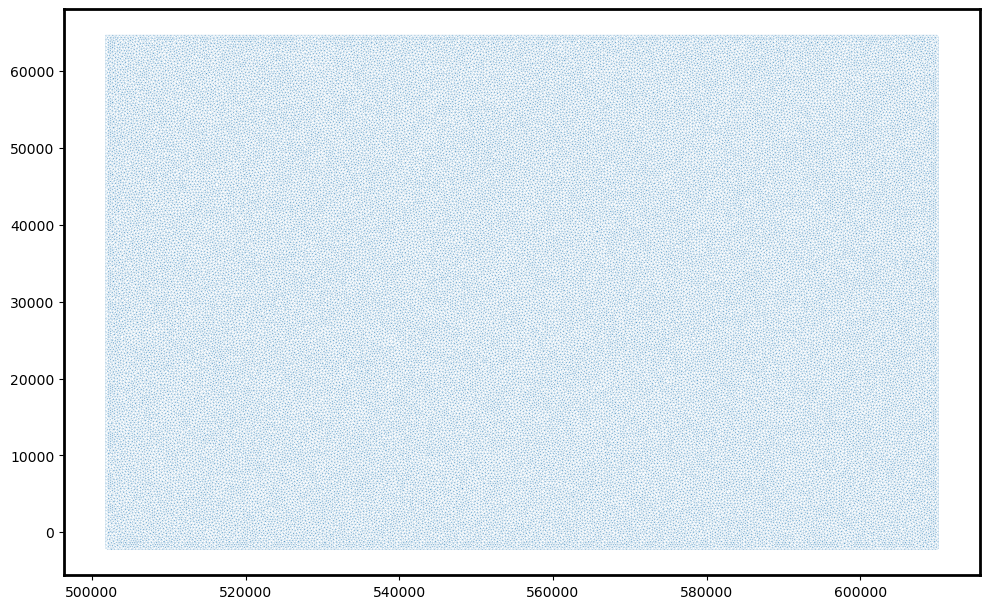

In [73]:
fig = plt.figure(figsize=(10,10))
dplotter = animate.Domain_plotter(domain,plot_dir = str(modelpath / 'plot'))
plt.triplot(dplotter.triang,linewidth=0.1)
plt.axis('scaled')
plt.tight_layout()
plt.savefig(modelpath / 'plot'/ ('mesh%s.png' %(myid)))

In [74]:
domain.print_algorithm_parameters()

#============================
# Domain Algorithm Parameters 
#============================
{   'CFL': 1.0,
    'alpha_balance': 2.0,
    'compute_fluxes_method': 'DE',
    'distribute_to_vertices_and_edges_method': 'DE',
    'extrapolate_velocity_second_order': True,
    'flow_algorithm': 'DE1',
    'g': 9.8,
    'low_froude': 0,
    'maximum_allowed_speed': 0.0,
    'minimum_allowed_height': 0.02,
    'minimum_storable_height': 0.001,
    'optimise_dry_cells': False,
    'optimised_gradient_limiter': True,
    'tight_slope_limiters': True,
    'timestepping_method': 'rk2',
    'use_centroid_velocities': True,
    'use_edge_limiter': True,
    'use_sloped_mannings': False}
#----------------------------


<font size=5 color='red'> Set tidal boundary and apply tide data </font>

In [75]:
start_tides = (datetime.strptime(startdate,'%Y%m%d') - datetime.strptime('20100101','%Y%m%d')).days * 24 +1
end_tides = start_tides + (simu_length) * 24 +1
stage_time_fun = scipy.interpolate.interp1d(
    tide_data[:simu_length*24+1, 0],
    tide_data[start_tides:end_tides, 1])



In [76]:
domain.set_boundary({'North': anuga.Reflective_boundary(domain), 'East': anuga.Reflective_boundary(domain), 'South': anuga.Reflective_boundary(domain), 'West': anuga.Time_boundary(domain,function=lambda t: [stage_time_fun(t),0.0,0.0])})

################################# Boundaries set as: 
North: Br
East: Br
South: Br
West: Bout


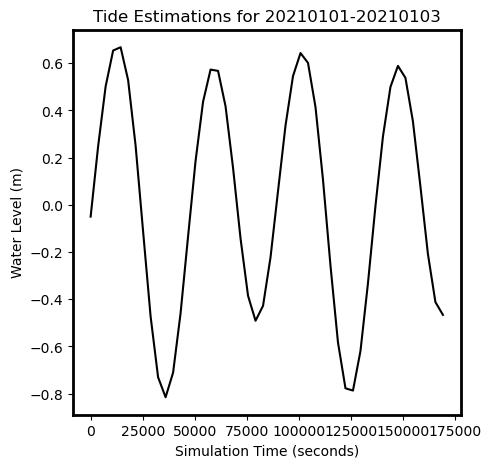

In [77]:
fig = plt.figure(figsize = (5,5), facecolor = 'w', edgecolor = 'k')
plt.plot(tide_data[:simu_length*24, 0], stage_time_fun(tide_data[:simu_length*24, 0]), color = 'black')
plt.xlabel("Simulation Time (seconds)")
plt.ylabel("Water Level (m)")
plt.title("Tide Estimations for %s-%s" %(startdate,enddate))
plt.savefig(modelpath / 'plot' / ('%s_tides.png' %(AOI)))

print('################################# Boundaries set as: \nNorth: %s\nEast: %s\nSouth: %s\nWest: %s' %('Br','Br','Br','Bout'))


<font size=5 color='red'> Set a point of discharge and set the steady state discharge value (m3/s)</font>

In [78]:
## Set upstream discharge boundary
center = (inletLON,inletLAT)
radius = 5000
fixed_inflow = None


In [79]:
line0 = [[center[0],center[1]],[center[0]-5,center[1]]]
fixed_inflow = Inlet_operator(domain,line0,Q=discharge,logging=True, description='upstream river', verbose = True)
if fixed_inflow is not None:
    print('################################# Discharge of %s m^3/s is input at (%s,%s)' %(discharge,center[0],center[1]))
    fixed_inflow.print_statistics()


P0 has 1 triangles in region line
Parallel Inlet Operator =================
Poly = line
Master Processor is P0
Processors are P[0]
################################# Discharge of 300 m^3/s is input at (608911.0,19092.0)
Parallel Inlet Operator: inlet_4_P0
Description
upstream river
Inlet
======> inlet triangle indices and centres and elevation at P0
[5736]
[[608965.9898653   19120.97886587]]
[-9.75428848]

Enquiry point:line
True



<font size=5 color='red'> Start the simulation! </font>

In [80]:
startnow = datetime.now()
print('################################# Starting Simulation at %s' %(startnow.strftime("%d/%m/%Y %H:%M:%S")))
print('################################# Simulation will run from %s to %s' %(startdate, enddate))
print('################################# Simulation length will be %s days, %s seconds' %(simu_length,simu_length*24*60*60))
print('################################# SWW file will be: ' + scenario )# Evolve system through time

sys.stdout.flush()

#------------------------------------------------------------------------------
for t in domain.evolve(yieldstep=900, duration=(simu_length*24*60*60)):
  domain.print_timestepping_statistics()
  #domain.report_water_volume_statistics()
  sys.stdout.flush()

endnow = datetime.now()
print('################################# Completed Simulation at %s' %(endnow.strftime("%d/%m/%Y %H:%M:%S")))

anuga.finalize()

################################# Starting Simulation at 29/06/2023 11:08:35
################################# Simulation will run from 20210101 to 20210103
################################# Simulation length will be 2 days, 172800 seconds
################################# SWW file will be: Test1
Time = 0.0000 (sec), steps=0 (33s)
Time = 900.0000 (sec), delta t in [2.03310336, 2.03558963] (s), steps=443 (26s)
Time = 1800.0000 (sec), delta t in [2.03160023, 2.03310172] (s), steps=443 (26s)
Time = 2700.0000 (sec), delta t in [2.03014217, 2.03159741] (s), steps=444 (26s)
Time = 3600.0000 (sec), delta t in [2.02867865, 2.03014166] (s), steps=444 (26s)
Time = 4500.0000 (sec), delta t in [2.02750145, 2.02867718] (s), steps=444 (26s)
Time = 5400.0000 (sec), delta t in [2.02683610, 2.02750021] (s), steps=444 (26s)
Time = 6300.0000 (sec), delta t in [2.02582851, 2.02683366] (s), steps=445 (26s)
Time = 7200.0000 (sec), delta t in [2.02479681, 2.02582825] (s), steps=445 (26s)
Time = 8100.0000 (se

Time = 87300.0000 (sec), delta t in [2.03581408, 2.03712700] (s), steps=442 (31s)
Time = 88200.0000 (sec), delta t in [2.03462250, 2.03581134] (s), steps=443 (26s)
Time = 89100.0000 (sec), delta t in [2.03338726, 2.03462191] (s), steps=443 (28s)
Time = 90000.0000 (sec), delta t in [2.03214895, 2.03338590] (s), steps=443 (26s)
Time = 90900.0000 (sec), delta t in [2.03093444, 2.03214685] (s), steps=444 (26s)
Time = 91800.0000 (sec), delta t in [2.02977555, 2.03093440] (s), steps=444 (26s)
Time = 92700.0000 (sec), delta t in [2.02858218, 2.02977483] (s), steps=444 (26s)
Time = 93600.0000 (sec), delta t in [2.02740802, 2.02858075] (s), steps=444 (26s)
Time = 94500.0000 (sec), delta t in [2.02657794, 2.02740595] (s), steps=445 (27s)
Time = 95400.0000 (sec), delta t in [2.02571007, 2.02657792] (s), steps=445 (26s)
Time = 96300.0000 (sec), delta t in [2.02483688, 2.02570969] (s), steps=445 (27s)
Time = 97200.0000 (sec), delta t in [2.02397454, 2.02483611] (s), steps=445 (27s)
Time = 98100.000

<font size=5 color='red'> Done running the model. Move on to the next notebook 6_Post_Process.ipynb </font>


<font size=3 > Computation time depends on your computer. For mine, 900s (15 minute) of simulation required 26s of real time. The full simulation (48 hours), required 1 hour and 20 minutes. </font>

In [81]:
print(scenario)
print(modelpath)

Test1
/Users/alchrist/Documents/GitHub/BAM/examples/komo/Simulations/Test1
